## 1. Load and Prepare Patient Data

In [1]:

import os
import pandas as pd

# Load 100 patient files from each dataset
def load_patients(path, limit=100):
    files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.psv')]
    patient_data = {}
    for file_path in files[:limit]:
        pid = os.path.basename(file_path).split(".")[0]
        df = pd.read_csv(file_path, sep='|')
        patient_data[pid] = df
    return patient_data

patients_A = load_patients('training_setA', 100)
patients_B = load_patients('training_setB', 100)

patient_dict = {**patients_A, **patients_B}
print(f"Loaded {len(patient_dict)} patients")


Loaded 200 patients


## 2. Apply MICE Imputation using `encode_dict_deltas`

In [2]:

import sys
from importlib.machinery import SourceFileLoader

mice_path = 'pipelines_le/mgbm_pipeline/src/models/mice/encode_data.py'
encode_data_module = SourceFileLoader("encode_data", mice_path).load_module()
encode_dict_deltas = encode_data_module.encode_dict_deltas

encoded_dict = encode_dict_deltas(patient_dict)
all_encoded_df = pd.concat(encoded_dict.values(), ignore_index=True)
all_encoded_df.head()


Encoding patients: 100%|██████████| 200/200 [00:04<00:00, 44.59it/s]


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,...,AST_delta1,AST_delta2,BUN_delta1,BUN_delta2,Alkalinephos_delta1,Alkalinephos_delta2,Calcium_delta1,Calcium_delta2,Chloride_delta1,Chloride_delta2,Creatinine_delta1,Creatinine_delta2,Bilirubin_direct_delta1,Bilirubin_direct_delta2,Glucose_delta1,Glucose_delta2,Lactate_delta1,Lactate_delta2,Magnesium_delta1,Magnesium_delta2,Phosphate_delta1,Phosphate_delta2,Potassium_delta1,Potassium_delta2,Bilirubin_total_delta1,Bilirubin_total_delta2,TroponinI_delta1,TroponinI_delta2,Hct_delta1,Hct_delta2,Hgb_delta1,Hgb_delta2,PTT_delta1,PTT_delta2,WBC_delta1,WBC_delta2,Fibrinogen_delta1,Fibrinogen_delta2,Platelets_delta1,Platelets_delta2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,NaN,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Select Features and Impute Remaining Missing Values

In [3]:

from sklearn.impute import SimpleImputer

# Keep columns with less than 20% missing values
missing_ratios = all_encoded_df.isnull().mean()
valid_features = missing_ratios[missing_ratios < 0.2].index.tolist()

# Drop unwanted columns
for col in ['SepsisLabel', 'SepsisLabel_delta', 'patient_id']:
    if col in valid_features:
        valid_features.remove(col)

X = all_encoded_df[valid_features]
y = all_encoded_df['SepsisLabel']

# Impute remaining missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


## 4. Train Random Forest Classifier

In [4]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Determine if each patient had sepsis (1) or not (0)
patient_labels = all_encoded_df.groupby("patient_id")["SepsisLabel"].max()

# Stratified split on patient sepsis occurrence
train_pids, test_pids = train_test_split(
    patient_labels.index, test_size=0.2, random_state=42, stratify=patient_labels
)

# Filter entire DataFrame based on patient IDs
train_mask = all_encoded_df['patient_id'].isin(train_pids)
test_mask = all_encoded_df['patient_id'].isin(test_pids)

X_train = X_imputed[train_mask]
X_test = X_imputed[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

## 5. Evaluate Model Performance

In [5]:

from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")


Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1184
           1       1.00      0.16      0.28        49

    accuracy                           0.97      1233
   macro avg       0.98      0.58      0.63      1233
weighted avg       0.97      0.97      0.96      1233

ROC AUC Score: 0.7426


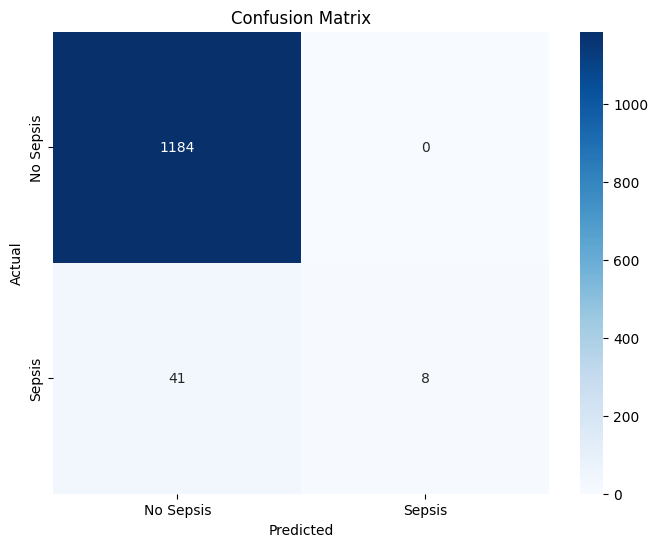

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()